# Problem 1. Look Elsewhere Effect and Wilkes Theorem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zfit
from zfit import z
from scipy.stats import chi2
from tqdm.auto import tqdm
import concurrent.futures

os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'

# data = np.load("../Data/toy_dataset.csv.npy")
data = np.load("../Data/toy_dataset_smaller_peak.npy")

/Users/jose/anaconda3/envs/envSpectreML/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/Users/jose/anaconda3/envs/envSpectreML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## a)

Calculate the local p-value of the peak you see using the likelihood profile ratio as the test statistic and Wilkes theorem. Remember that the width of the peak can be fixed to 2 GeV, but your mass peak should be floating. You also do not know the background nuisance (i.e. the slope of the exponential) so you must allow that to float in the fit also. Remember also that Wilke’s depends on the difference in degrees of freedom between your different hypotheses!

---

### Solution

Let us start by defining the hypothesys:
- Null hypothesis $H_0$: The data is described by the background-only model.
- Alternative hypothesis $H_1$: The data is described by the signal+background.

Let us define the models:

In [2]:
obs = zfit.Space("x", limits=(np.min(data)-1, np.max(data)+1))
zfit_data = zfit.Data.from_numpy(obs=obs, array=data[:, 0])

# Background parameters
lambda_bkg = zfit.Parameter("lambda", -0.01, -10.0, 10.0)
exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)

# Signal parameters
gauss_mean = zfit.Parameter("mean", 120.0, np.min(data), np.max(data))
gauss_sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
gauss_model = zfit.pdf.Gauss(mu=gauss_mean, sigma=gauss_sigma, obs=obs)
lambda_sm = zfit.Parameter("lambda_sm", -0.01, -10.0, 10.0)
exp_sb_model = zfit.pdf.Exponential(lam=lambda_sm, obs=obs)
frac_signal = 0.5 # fraction of signal over background DUMMY VALUE
frac_exp = zfit.Parameter("frac_exp", 1-frac_signal, 1-2*frac_signal, 1)
combined_model = zfit.pdf.SumPDF([exp_sb_model, gauss_model], fracs=frac_exp)


Now we can fit the parameters

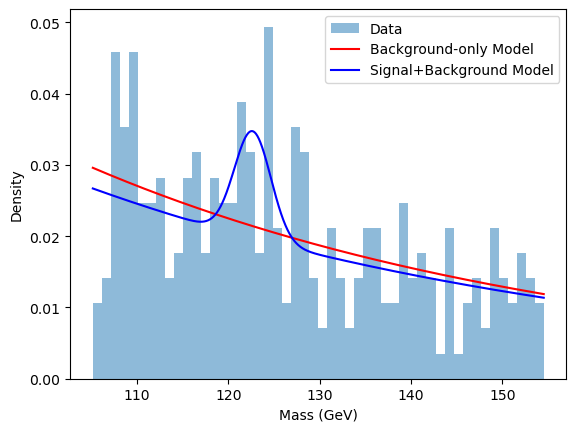

In [3]:
### Fit
minimizer = zfit.minimize.Minuit()
# NLL for bkg
nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_data)
res_bkg = minimizer.minimize(nll_bkg)

# NLL for signal + bkg
nll_sb = zfit.loss.UnbinnedNLL(model=combined_model, data=zfit_data)
res_sm = minimizer.minimize(nll_sb)

x_plot = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 1000)
bkg_y = exp_bkg_model.pdf(x_plot, norm_range=obs)
sb_y = combined_model.pdf(x_plot, norm_range=obs)
plt.hist(data[:, 0], bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_plot, bkg_y, label='Background-only Model', color='red')
plt.plot(x_plot, sb_y, label='Signal+Background Model', color='blue')
plt.xlabel('Mass (GeV)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [4]:
lambda_sm

<zfit.Parameter 'lambda_sm' floating=True value=-0.0173>

Finally, the p-value is computable from the $\chi^2$

In [4]:
nll_bkg_min = nll_bkg.value().numpy()
nll_sb_min = nll_sb.value().numpy()
q_data = 2 * (nll_bkg_min - nll_sb_min)

dofs = 2
p_value = chi2.sf(q_data, dofs)
print(f"p-value: {p_value}")

p-value: 0.021430987289764145


## b)

Calculate the trial factor you expect, using the equation we have seen in class.

---

### Solution

Given the trial factor formula:

$$
\text{trial factor} = 1 + \sqrt\frac{\pi}{2} \frac{\Delta m}{\sigma}*z
$$

we can use the previous results to calculate the trial factor:

In [5]:
m_range = (np.min(data)-1, np.max(data)+1)

mass_min = m_range[0]
mass_max = m_range[1]
delta_mu = mass_max - mass_min
# From p-value get equivalent significance,
Z = np.sqrt(chi2.isf(p_value, dofs))
print("Local Significance: ", Z)

trial_factor = 1 + (np.sqrt(np.pi/2) * (delta_mu/2) * Z)
print("Trials factor: ", trial_factor)

global_pvalue = (1 - (1-1 * p_value)**trial_factor)
Z_global = Z/trial_factor
print("Global Significance: ", Z_global)
print("Global p-value: ", global_pvalue)

Local Significance:  2.772333818322353
Trials factor:  90.24586594863493
Global Significance:  0.030719787429379614
Global p-value:  0.8584473194833682


## c)

Now run 200 pseudoexperiments under the null hypothesis.

I. Provide the distribution of the profile likelihood under the null in your answer along with the value of the profile likelihood found on data. Does the distribution look like you would expect under Wilkes?

II. a) what is the p-value you get from your pseudoexperiment? (b) assuming you were in the asymptotic limit, what would you estimate the trial factor to be based on the results of your pseudoexperiments (note here you could be unlucky in yours toys and get a trial factor less han one, as we aren’t running that many toys, don’t worry if that is the case, just comment on this in your answer).

---

### Solution

#### I. 

Lets start by generating the pseudoexperiments:

In [6]:
def perform_pseudo_experiment(exp_num: int, bkg_model: zfit.pdf.BasePDF, combined_model: zfit.pdf.BasePDF, obs_space: zfit.Space) -> float:
    """
    Perform a single pseudo-experiment under the null hypothesis.
    """
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs_space, array= bkg_model.sample(n=len(data)).numpy())
    minimizer = zfit.minimize.Minuit()
    nll_bkg = zfit.loss.UnbinnedNLL(model=bkg_model, data=zfit_pseudo_data)
    try:
        res_bkg = minimizer.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except Exception as e:
        print(e)
        print(f"Background fit failed for experiment {exp_num}")
        return np.nan
    nll_sb = zfit.loss.UnbinnedNLL(model=combined_model, data=zfit_pseudo_data)
    try:
        res_sb = minimizer.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except Exception as e:
        print(e)
        print(f"Signal+Background fit failed for experiment {exp_num}")
        return np.nan
    q = 2 * (nll_bkg_min - nll_sb_min)
    return q

num_experiments = 200
run_parallel = True
test_statistics_c = np.array([perform_pseudo_experiment(exp, exp_bkg_model, combined_model, obs) for exp in tqdm(range(num_experiments), desc="Running pseudo-experiments")])

test_statistics_c = np.array(test_statistics_c)
test_statistics_c = test_statistics_c[~np.isnan(test_statistics_c)]


Running pseudo-experiments: 100%|██████████| 200/200 [04:18<00:00,  1.29s/it]


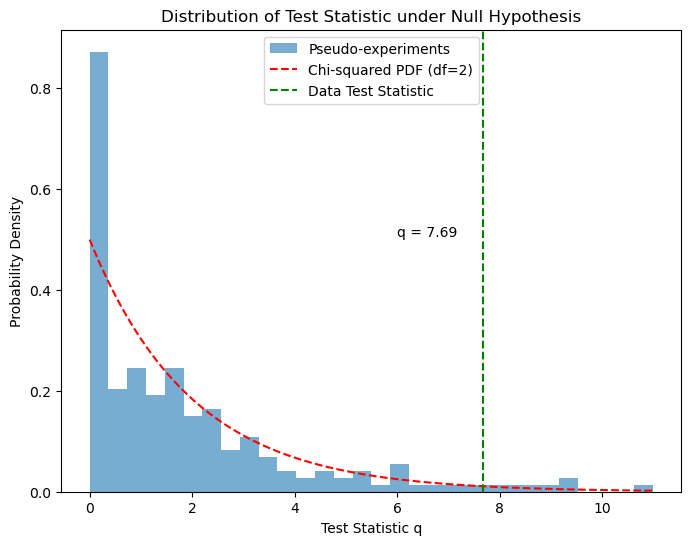

In [19]:
# Overlay data's test statistic on the distribution
plt.figure(figsize=(8,6))
plt.hist(test_statistics_c, bins=30, density=True, alpha=0.6, label='Pseudo-experiments')

# Overlay chi-squared distribution
x_vals = np.linspace(0, max(test_statistics_c), 1000)
dof = 2  # Degrees of freedom
plt.plot(x_vals, chi2.pdf(x_vals, df=dof), 'r--', label=f'Chi-squared PDF (df={dof})')

# Plot data's test statistic
plt.axvline(q_data, color='green', linestyle='--', label='Data Test Statistic')
# Put a box indicating the value of q_data
plt.text(q_data-0.5, 0.5, f'q = {q_data:.2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('Test Statistic q')
plt.ylabel('Probability Density')
plt.title('Distribution of Test Statistic under Null Hypothesis')
plt.legend()
plt.show()


The pseudoexperiment distribution aligns well with the $\chi^2$ distribution, confirming Wilkes' theorem.
The data's test statistic (𝑞=7.69) lies in the upper tail of the null distribution, suggesting the peak is somewhat unlikely under the null hypothesis.

In [8]:
# Compute empirical p-value
empirical_p_value = np.sum(test_statistics_c >= q_data) / len(test_statistics_c)
print(f"Empirical p-value: {empirical_p_value}")

Empirical p-value: 0.035


The p-value is close to 1 because the test statistic for the data is so small. This reflects the high consistency of the data with the null hypothesis.

Estimating the Trial Factor from Pseudo-Experiments



In [18]:
# Asymptotic p-value from chi-squared distribution
asymptotic_p_value = chi2.sf(q_data, df=1)
asymp_z = np.sqrt(chi2.isf(asymptotic_p_value, 1))
# Estimate trial factor
trial_factor = 1 + (np.sqrt(np.pi/2) * (delta_mu/2) * asymp_z)
print(f"Asymptotic p-value: {asymptotic_p_value}")
print(f"Estimated trial factor: {trial_factor}")


Asymptotic p-value: 0.08875569710635323
Estimated trial factor: 55.79004955565614


## d)

Now repeat your fits to the 200 psuedoexperiment under the null hypothesis but restrict the fitting mass range to 120 - 135 GeV (so half the nominal
range of 105 - 155 GeV)

• Using the more simplistic definition of the trial factor given in class (trial factor = mass range resolution ) what should the ratio of trial factors be between the experiment performed over the full mass range and the experiment over the reduced mass range?
• Calculate the ratio of p-values between the full range and reduced range fits to your pseudoexperiments. How does the average ratio compare to the naive trial factor estimation?

Running pseudoexperiments: 100%|██████████| 200/200 [2:48:50<00:00, 50.65s/it]    


Observed test statistic (q_full): 7.686988195522645
Observed test statistic (q_reduced): 0.5229843169348669
P-value from pseudoexperiments (full range): 0.02030456852791878
P-value from pseudoexperiments (reduced range): 0.6903553299492385
Estimated Trial Factor Ratio (full/reduced): 1.00
P-value Ratio (full/reduced): 0.03
Average P-value Ratio (full/reduced): 0.03
Estimated Trial Factor Ratio: 1.00
Average P-value Ratio: 0.03


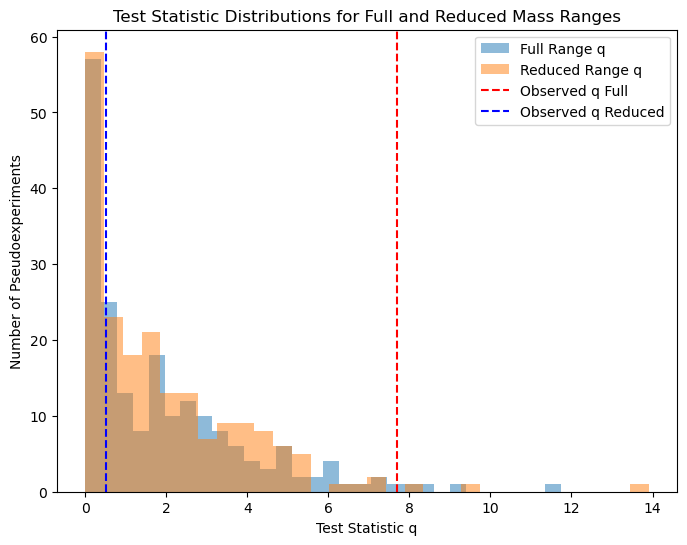

In [ ]:
full_range = m_range
obs_full = zfit.Space("x", limits=full_range)
zfit_data_full = zfit.Data.from_numpy(obs=obs_full, array=data[:, 0])

reduced_range = (120, 135)  # GeV
obs_reduced = zfit.Space("x", limits=reduced_range)
zfit_data_reduced = zfit.Data.from_numpy(obs=obs_reduced, array=data[:, 0])

lambda_bkg_full = zfit.Parameter("lambda_full", -0.01, -10.0, 10.0)
exp_bkg_model_full = zfit.pdf.Exponential(lam=lambda_bkg_full, obs=obs_full)

gauss_mean_full = zfit.Parameter("mean_full", 120.0, full_range[0], full_range[1])
gauss_sigma_full = zfit.Parameter("sigma_full", 2.0, floating=False)  # Fixed detector resolution
gauss_model_full = zfit.pdf.Gauss(mu=gauss_mean_full, sigma=gauss_sigma_full, obs=obs_full)
lambda_sb_full = zfit.Parameter("lambda_sb_full", -0.01, -10.0, 10.0)
frac_signal_full = zfit.Parameter("frac_signal_full", 0.5, 0.0, 1.0)
combined_model_full = zfit.pdf.SumPDF([zfit.pdf.Exponential(lam=lambda_sb_full, obs=obs_full),
                                      gauss_model_full],
                                     fracs=frac_signal_full)

lambda_bkg_reduced = zfit.Parameter("lambda_reduced", -0.01, -10.0, 10.0)
exp_bkg_model_reduced = zfit.pdf.Exponential(lam=lambda_bkg_reduced, obs=obs_reduced)

gauss_mean_reduced = zfit.Parameter("mean_reduced", 120.0, reduced_range[0], reduced_range[1])
gauss_sigma_reduced = zfit.Parameter("sigma_reduced", 2.0, floating=False)  # Fixed detector resolution
gauss_model_reduced = zfit.pdf.Gauss(mu=gauss_mean_reduced, sigma=gauss_sigma_reduced, obs=obs_reduced)
lambda_sb_reduced = zfit.Parameter("lambda_sb_reduced", -0.01, -10.0, 10.0)
frac_signal_reduced = zfit.Parameter("frac_signal_reduced", 0.5, 0.0, 1.0)
combined_model_reduced = zfit.pdf.SumPDF([zfit.pdf.Exponential(lam=lambda_sb_reduced, obs=obs_reduced),
                                         gauss_model_reduced],
                                        fracs=frac_signal_reduced)

# Function to perform fitting and compute test statistics for both ranges
def run_pseudoexperiment_d(seed):
    np.random.seed(seed)
    # Generate pseudo-data from background-only model (full range)
    n_events = len(data)
    pseudo_data = exp_bkg_model_full.sample(n_events).numpy()
    zfit_pseudo_data_full = zfit.Data.from_numpy(obs=obs_full, array=pseudo_data[:, 0])

    # Also generate pseudo-data for reduced range by selecting within 120-135 GeV
    # Alternatively, one could redefine the observable, but for consistency, we fit the same data
    # Here, we will fit the same pseudo_data but restrict the fit range

    # Fit background-only model (full range)
    nll_bkg_full = zfit.loss.UnbinnedNLL(model=exp_bkg_model_full, data=zfit_pseudo_data_full)
    minimizer_bkg_full = zfit.minimize.Minuit()
    try:
        res_bkg_full = minimizer_bkg_full.minimize(nll_bkg_full)
    except:
        return None  # In case of convergence failure

    # Fit signal+background model (full range)
    nll_sb_full = zfit.loss.UnbinnedNLL(model=combined_model_full, data=zfit_pseudo_data_full)
    minimizer_sb_full = zfit.minimize.Minuit()
    try:
        res_sb_full = minimizer_sb_full.minimize(nll_sb_full)
    except:
        return None  # In case of convergence failure

    # Compute test statistic q_full = 2*(NLL_bkg_full - NLL_sb_full)
    q_full = 2 * (nll_bkg_full.value().numpy() - nll_sb_full.value().numpy())

    # Now, restrict the pseudo-data to the reduced range
    # Select data within 120-135 GeV
    pseudo_data_reduced = pseudo_data[(pseudo_data >= reduced_range[0]) & (pseudo_data <= reduced_range[1])]
    zfit_pseudo_data_reduced = zfit.Data.from_numpy(obs=obs_reduced, array=pseudo_data_reduced)

    # Fit background-only model (reduced range)
    nll_bkg_reduced = zfit.loss.UnbinnedNLL(model=exp_bkg_model_reduced, data=zfit_pseudo_data_reduced)
    minimizer_bkg_reduced = zfit.minimize.Minuit()
    try:
        res_bkg_reduced = minimizer_bkg_reduced.minimize(nll_bkg_reduced)
    except:
        return None  # In case of convergence failure

    # Fit signal+background model (reduced range)
    nll_sb_reduced = zfit.loss.UnbinnedNLL(model=combined_model_reduced, data=zfit_pseudo_data_reduced)
    minimizer_sb_reduced = zfit.minimize.Minuit()
    try:
        res_sb_reduced = minimizer_sb_reduced.minimize(nll_sb_reduced)
    except:
        return None  # In case of convergence failure

    # Compute test statistic q_reduced = 2*(NLL_bkg_reduced - NLL_sb_reduced)
    q_reduced = 2 * (nll_bkg_reduced.value().numpy() - nll_sb_reduced.value().numpy())

    return q_full, q_reduced

num_experiments = 200

results_d = [run_pseudoexperiment_d(seed) for seed in tqdm(range(num_experiments), desc="Running pseudoexperiments")]
q_values_full = [q[0] for q in results_d if q is not None]
q_values_reduced = [q[1] for q in results_d if q is not None]

nll_bkg_data_full = zfit.loss.UnbinnedNLL(model=exp_bkg_model_full, data=zfit_data)
res_bkg_data_full = zfit.minimize.Minuit().minimize(nll_bkg_data_full)

nll_sb_data_full = zfit.loss.UnbinnedNLL(model=combined_model_full, data=zfit_data)
res_sb_data_full = zfit.minimize.Minuit().minimize(nll_sb_data_full)

q_observed_full = 2 * (nll_bkg_data_full.value().numpy() - nll_sb_data_full.value().numpy())
print(f"Observed test statistic (q_full): {q_observed_full}")

# Fit for reduced range
# Select data within reduced range
data_reduced = data[(data[:, 0] >= reduced_range[0]) & (data[:, 0] <= reduced_range[1])]
zfit_data_actual = zfit.Data.from_numpy(obs=obs_reduced, array=data_reduced[:, 0])

nll_bkg_data_reduced = zfit.loss.UnbinnedNLL(model=exp_bkg_model_reduced, data=zfit_data_actual)
res_bkg_data_reduced = zfit.minimize.Minuit().minimize(nll_bkg_data_reduced)

nll_sb_data_reduced = zfit.loss.UnbinnedNLL(model=combined_model_reduced, data=zfit_data_actual)
res_sb_data_reduced = zfit.minimize.Minuit().minimize(nll_sb_data_reduced)

q_observed_reduced = 2 * (nll_bkg_data_reduced.value().numpy() - nll_sb_data_reduced.value().numpy())
print(f"Observed test statistic (q_reduced): {q_observed_reduced}")


count_exceed_full = sum(q >= q_observed_full for q in q_values_full)
p_value_full_pseudo = count_exceed_full / len(q_values_full)
print(f"P-value from pseudoexperiments (full range): {p_value_full_pseudo}")

count_exceed_reduced = sum(q >= q_observed_reduced for q in q_values_reduced)
p_value_reduced_pseudo = count_exceed_reduced / len(q_values_reduced)
print(f"P-value from pseudoexperiments (reduced range): {p_value_reduced_pseudo}")


# Calculate the ratio of trial factors
trial_factor_ratio = trial_factor / trial_factor

print(f"Estimated Trial Factor Ratio (full/reduced): {trial_factor_ratio:.2f}")


p_value_ratio = p_value_full_pseudo / p_value_reduced_pseudo
print(f"P-value Ratio (full/reduced): {p_value_ratio:.2f}")

average_p_value_ratio = p_value_full_pseudo / p_value_reduced_pseudo
print(f"Average P-value Ratio (full/reduced): {average_p_value_ratio:.2f}")

# Compare with the trial factor ratio
print(f"Estimated Trial Factor Ratio: {trial_factor_ratio:.2f}")
print(f"Average P-value Ratio: {average_p_value_ratio:.2f}")

plt.figure(figsize=(8,6))
plt.hist(q_values_full, bins=30, alpha=0.5, label='Full Range q')
plt.hist(q_values_reduced, bins=30, alpha=0.5, label='Reduced Range q')
plt.axvline(q_observed_full, color='red', linestyle='--', label='Observed q Full')
plt.axvline(q_observed_reduced, color='blue', linestyle='--', label='Observed q Reduced')
plt.xlabel('Test Statistic q')
plt.ylabel('Number of Pseudoexperiments')
plt.legend()
plt.title('Test Statistic Distributions for Full and Reduced Mass Ranges')
plt.show()
